# GRAD-E1426 Network Analysis: Assignment 2 
#### Janine De Vera, 219848

## Characterizing the Scope and Depth of Trade Agreements

Over the last half century, the world has seen historic changes in the international trade landscape, marked by increasing fragmentation of production processes through global value chains and deepening of trade relations through the proliferation of **preferential trade agreements (PTAs)**. Based on the World Trade Organization's database, the number of trade agreements in force grew six-fold from 50 in 1990 to 306 in 2020. 

With the sharp rise in trade agreements came a new interest in their depth and scope. Before the mid 1990s, PTAs mostly invovled provisions for market access and preferential tariffs. The last 30 years have seen a spread of contemporary forms of cooperation, specifically *deeper* agreements which involve provisions such as regulatory issues, intellectual property, human rights, political dialogue and investment. 

This network analysis aims to characterize how trade agreements have developed over the last 50 years -- how deep have they become, who are the key players or regions involved. 

In [525]:
import graph_tool.all as gt
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.pyplot import clf, xlabel, ylabel, imshow, colorbar, savefig
import pandas as pd
import numpy as np
import os
import math


In [526]:
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Semester 4/2 Network Analysis/Assignments/network-analysis-trade-agreements/code'

## I. Data

For this analysis, I use World Bank's *Horizontal Trade Agreements Database*. This dataset contains preferential trade agreements (PTAs) notified to the World Trade Organization as of 2015, year of enforcement, type, and variables indicating the presence (or absence) of PTA provisions. All information is recorded bilaterally, as seen below. 

The _**depth**_ variable, pertaining to the depth or scope of a trade agreement, is calculated by summing the number of key PTA provisions that appear in a particular agreement. The maximum possible value is 52.

There are two main types of provisions - _**wto_plus**_ and _**wto_x**_. The former includes PTA provisions under the mandate of the WTO. This includes anti-dumping policies, customs duties and export taxes. The latter, _**wto_x**_ (WTO extra), pertains to provisions outside the mandate of the WTO such as consumer protection, environmental laws and immigration policies.

In [190]:
pta = pd.read_excel("../data/WB_Bilateral PTAs_2018.xlsx")

In [191]:
pta['depth'] = pta.filter(regex=r'^wto(?!.*_le$)').sum(axis=1)
pta['depth_le'] = pta.filter(regex=r'^wto.*_le$').sum(axis=1)
pta.head()

cty1 iso1     cty2 iso2  year agreement  entry_force type   
0  Angola  AGO  Burundi  BDI  1994    COMESA         1994   CU  \
1  Angola  AGO  Burundi  BDI  1995    COMESA         1994   CU   
2  Angola  AGO  Burundi  BDI  1996    COMESA         1994   CU   
3  Angola  AGO  Burundi  BDI  1997    COMESA         1994   CU   
4  Angola  AGO  Burundi  BDI  1998    COMESA         1994   CU   

   wto_plus_ftaindustrial  wto_plus_ftaagriculture  ...   
0                       1                        1  ...  \
1                       1                        1  ...   
2                       1                        1  ...   
3                       1                        1  ...   
4                       1                        1  ...   

   wto_X_regionalcooperation_le  wto_X_researchandtechnology_le  wto_X_sme_le   
0                             0                               0             0  \
1                             0                               0             0   
2                             0                               0             0   
3                             0                               0             0   
4                             0                               0             0   

   wto_X_socialmatters_le  wto_X_statistics_le  wto_X_taxation_le   
0                       0                    0                  0  \
1                       0                    0                  0   
2                       0                    0                  0   
3                       0                    0                  0   
4                       0                    0                  0   

   wto_X_terrorism_le  wto_X_visaandasylum_le  depth  depth_le  
0                   0                       0     29        22  
1                   0                       0     29        22  
2                   0                       0     29        22  
3                   0                       0     29        22  
4                   0                       0     29        22  

[5 rows x 114 columns]

In [261]:
# indicator variable for wto_x
pta['wto_x'] = 0
for column in pta.columns:
    if column.startswith("wto_X_"):
        pta['wto_x'] = pta['wto_x'] | (pta[column] > 0)
pta['wto_x'] = pta['wto_x'].astype(int)

# indicator variable for wto_x_le
pta['wto_x_le'] = 0
for column in pta.columns:
    if "wto_X" in column and "_le" in column:
        pta['wto_x_le'] = pta['wto_x_le'] | (pta[column] > 1)
pta['wto_x_le'] = pta['wto_x_le'].astype(int)

# indicator variable for wto_x_core
pta['wto_x_core'] = 0
for column in pta.columns:
    if column in ['wto_X_competitionpolicy_le', 'wto_X_ipr_le', 'wto_X_investment_le', 'wto_X_movementofcapital_le']:
        pta['wto_x_core'] = pta['wto_x_core'] | (pta[column] > 0)
pta['wto_x_core'] = pta['wto_x_core'].astype(int)

# indicator variable for wto_x_nonecon
non_econ = ['wto_X_environmentallaws_le', 'wto_X_audiovisual_le', 'wto_X_culturalcooperation_le', 'wto_X_health_le',
            'wto_X_humanrights_le', 'wto_X_illicitdrugs_le', 'wto_X_moneylaundering_le', 'wto_X_politicaldialogue_le']
pta['wto_x_nonecon'] = 0
for column in pta.columns:
    if column in non_econ:
        pta['wto_x_nonecon'] = pta['wto_x_nonecon'] | (pta[column] > 0)
pta['wto_x_nonecon'] = pta['wto_x_nonecon'].astype(int)

I also supplement this dataset with other country-level information such as broad geographic region, economy size (GVA), and income classification.

*Region*

In [7]:
regions = pd.read_excel("../data/WB_regions.xls", skiprows=4, index_col=0)

In [8]:
regions = regions[['Economy', 'Code', 'Region_Clean', 'Income group']].dropna(subset = ['Region_Clean'])
regions.head()

Economy Code                Region_Clean         Income group
x                                                                      
1     Afghanistan  AFG                  South Asia           Low income
2         Albania  ALB                      Europe  Upper middle income
3         Algeria  DZA  Middle East & North Africa  Lower middle income
4  American Samoa  ASM         East Asia & Pacific  Upper middle income
5         Andorra  AND                      Europe          High income

*Economy size*

In [791]:
economy = pd.read_excel("../data/WB_economy.xlsx", skiprows = 4)
economy = economy.iloc[:, [1, 62]].rename(columns={economy.columns[62]: 'gva'})

The merged dataset _**trade_df**_ is constructed such that each observation is unique for a country-pair and agreement.

In [792]:
# merge datasets
trade_df = pd.merge(pta, regions, left_on='iso1', right_on='Code')
trade_df = pd.merge(trade_df, economy, left_on='iso1', right_on='Country Code')

In [793]:
# remove duplicate pairs
trade_df['sorted_iso'] = trade_df[['iso1', 'iso2']].apply(lambda x: tuple(sorted(x)), axis=1)
trade_df = trade_df.drop_duplicates(subset=['sorted_iso', 'agreement'], keep='first')


## II. Network Plots

Next, I structure and prepare the data in a way that is compatible with the **Graph()** class of graph tool. Among other things, I create a list of unique countries which will serve as nodes and country-pair agreements which will serve as edges. I also add name properties for nodes and edges are added for ease of reference.

### A. Creating *graph* object

In [570]:
# unique nodes and edge country pair agreements
nodes = trade_df['iso1'].drop_duplicates()
pairs = trade_df[['iso1', 'iso2', 'agreement']].drop_duplicates(keep='first')

# edge pairs as list of tuples 
pairs = list(zip(pairs.iso1, pairs.iso2))

I then create the Graph object and define the nodes and edges.

In [797]:
# instantiate undirected Graph object
trade_graph = gt.Graph(directed=False)

In [798]:
# add nodes and edges from pairs list, create country_name and pair_name as properties
country_name = trade_graph.new_vertex_property('string')
pair_name = trade_graph.new_edge_property('object')

node_list = {}
for pair in pairs:
    for name in pair:
        if name not in node_list:
            v = trade_graph.add_vertex()
            node_list[name] = v
            country_name[v] = name
    e = trade_graph.add_edge(node_list[pair[0]], node_list[pair[1]])
    pair_name[e] = (pair[0], pair[1]) 

trade_graph.vertex_properties["country_name"] = country_name
trade_graph.edge_properties["pair_name"] = pair_name

In [730]:
pos = gt.sfdp_layout(trade_graph)
#pos = gt.fruchterman_reingold_layout(trade_graph, n_iter=500)

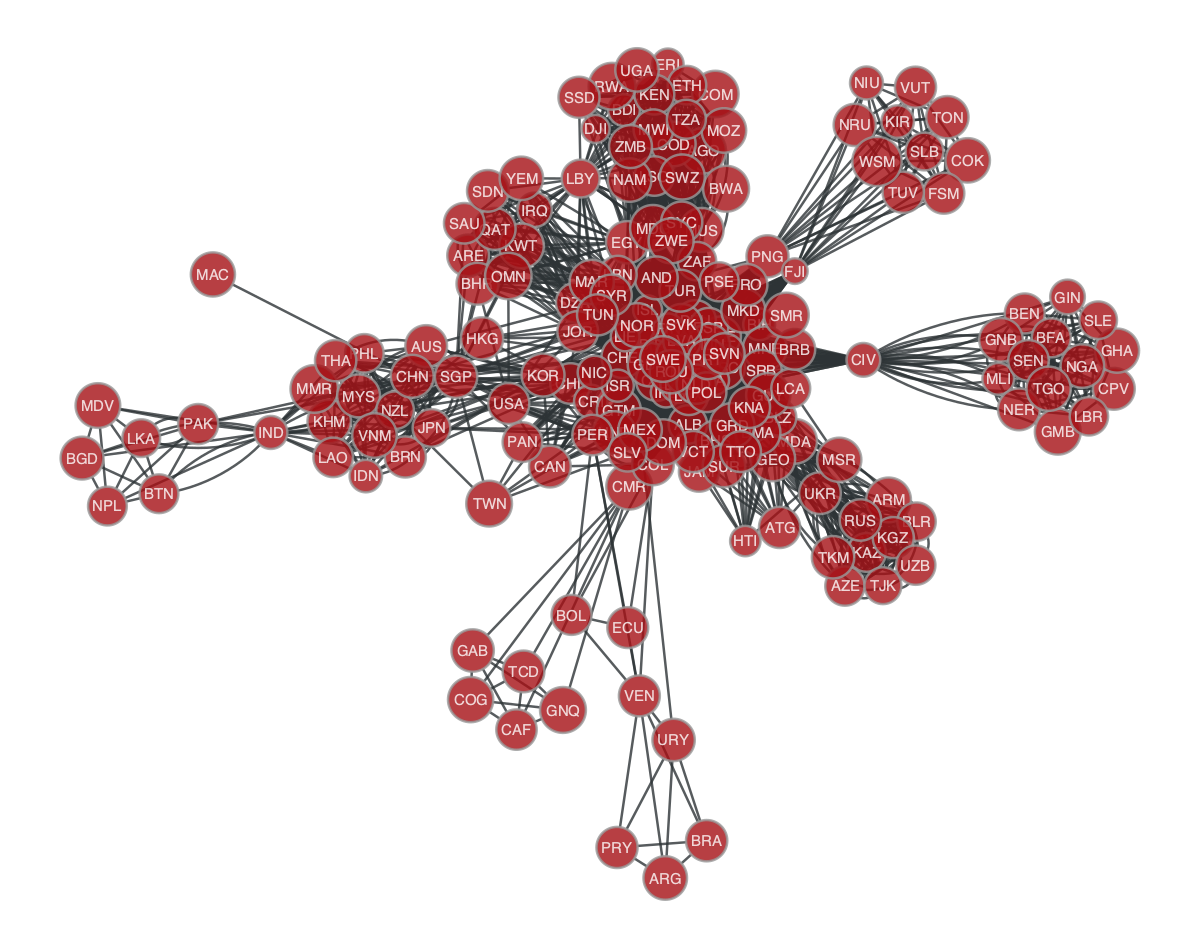

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c96cfa0, at 0x15c961280>

In [799]:
gt.graph_draw(trade_graph, pos = pos, vertex_text = country_name, vertex_font_family='sans serif')

### B. Node and edge properties

I also add other country-level and agreement-level information as properties to the graph. Node colors correspond to a country's geographical region, edge weight corresponds to PTA depth, and edge color corresponds to whether an agreement contains provisions not mandated by the WTO (_**wto_x**_). 

#### i. Nodes

In [910]:
def add_node_property(node_property_type, dictionary):
    node_property = trade_graph.new_vertex_property(node_property_type)

    for v in trade_graph.vertices():
        name = trade_graph.vp.country_name[v]
        if name in dictionary:
            node_property[v] = dictionary[name]
        else:
            trade_graph.remove_vertex(v)
    return node_property

*Node color: region*

In [800]:
# list of unique country names and corresponding region
country1 = trade_df[['iso1']]
country2 = trade_df[['iso2']].rename(columns={'iso2': 'iso1'})

countries_all = pd.concat([country1, country2], ignore_index = True).drop_duplicates(keep='first')
countries_all = pd.merge(countries_all, regions, left_on='iso1', right_on='Code')[['iso1', 'Region_Clean']]

In [814]:
# region-color dictionary  
region_colors = {'Sub-Saharan Africa':'#FA9265', # orange
                 'Europe': '#7ACCE1', # blue
                 'Middle East & North Africa': '#FA9265', # orange
                 'Latin America & Caribbean': '#90BC62', # green
                 'East Asia & Pacific': '#C7448C', # pink
                 'Central Asia': '#C7448C', # pink
                 'South Asia': '#C7448C', # pink
                 'North America': '#A68FC7'} # purple

# map colors to regions
countries_all['region_colors'] = countries_all['Region_Clean'].map(region_colors)

# node color dictionary
node_color_dict = (
    countries_all[['iso1', 'region_colors']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['region_colors']
    )

In [815]:
node_color = add_node_property('string', node_color_dict)
trade_graph.vertex_properties["node_color"] = node_color

*Node filter: region*

In [911]:
# node region dictionary
node_region_dict = (
    countries_all[['iso1', 'Region_Clean']]
    .drop_duplicates()
    .set_index('iso1')
    .to_dict()['Region_Clean']
    )

In [912]:
node_region = add_node_property('string', node_region_dict)
trade_graph.vertex_properties["node_region"] = node_region

#### ii. Edges

For the edges, I create a function which adds different edge properties from the _**trade_df**_ dataframe.

In [820]:
def add_edge_property(edge_property_type, dictionary, default_val=0):
    edge_property = trade_graph.new_edge_property(edge_property_type)
    for e in trade_graph.edges():
        name = trade_graph.ep.pair_name[e]
        if name in dictionary:
            edge_property[e] = dictionary[name]
        else:
            edge_property[e] = default_val  # set default value if not found in the dictionary
    return edge_property

*Edge weight: depth of trade agreements*

In [830]:
# define edge weight dictionary
edge_size_dict = (
    trade_df[['sorted_iso', 'depth_le']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['depth_le']
    )

In [831]:
# add edge property
edge_weight = add_edge_property(edge_property_type='float', dictionary=edge_size_dict, default_val=0)
trade_graph.edge_properties['edge_weight'] = edge_weight

*Edge color: legal enforceability of non-economic provisions*

In [832]:
# agreement-color dictionary  
wto_colors = {1:'#FAEABA', # yellow
              0: '#EBEBEB'} # white

# map colors to agreements
trade_df['wto_colors'] = trade_df['wto_x_nonecon'].map(wto_colors)

# define edge color dictionary
edge_colors_dict = (
    trade_df[['sorted_iso', 'wto_colors']]
    .drop_duplicates()
    .set_index('sorted_iso')
    #.apply(lambda x: {'wto_colors': x['wto_colors'], 'wto_x_nonecon': x['wto_x_nonecon']}, axis=1)
    .to_dict()['wto_colors']
    )

In [826]:
edge_color = add_edge_property(edge_property_type='string', dictionary=edge_colors_dict, default_val='#EBEBEB')
trade_graph.edge_properties['edge_color'] = edge_color

*Edge filter: legal enforceability of non-economic provisions*

In [828]:
# define edge color dictionary
edge_nonecon_dict = (
    trade_df[['sorted_iso', 'wto_x_nonecon']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['wto_x_nonecon']
    )

In [829]:
edge_nonecon_prov = add_edge_property(edge_property_type='float', dictionary=edge_nonecon_dict, default_val=0)
trade_graph.edge_properties['edge_nonecon_prov'] = edge_nonecon_prov

*Edge filter: year agreement entry in force*

In [833]:
# define year dictionary
edge_year_dict = (
    trade_df[['sorted_iso', 'entry_force']]
    .drop_duplicates()
    .set_index('sorted_iso')
    .to_dict()['entry_force']
    )

In [834]:
edge_year= add_edge_property(edge_property_type='int', dictionary=edge_year_dict, default_val=0)
trade_graph.edge_properties['edge_year'] = edge_year

### C. Plot network

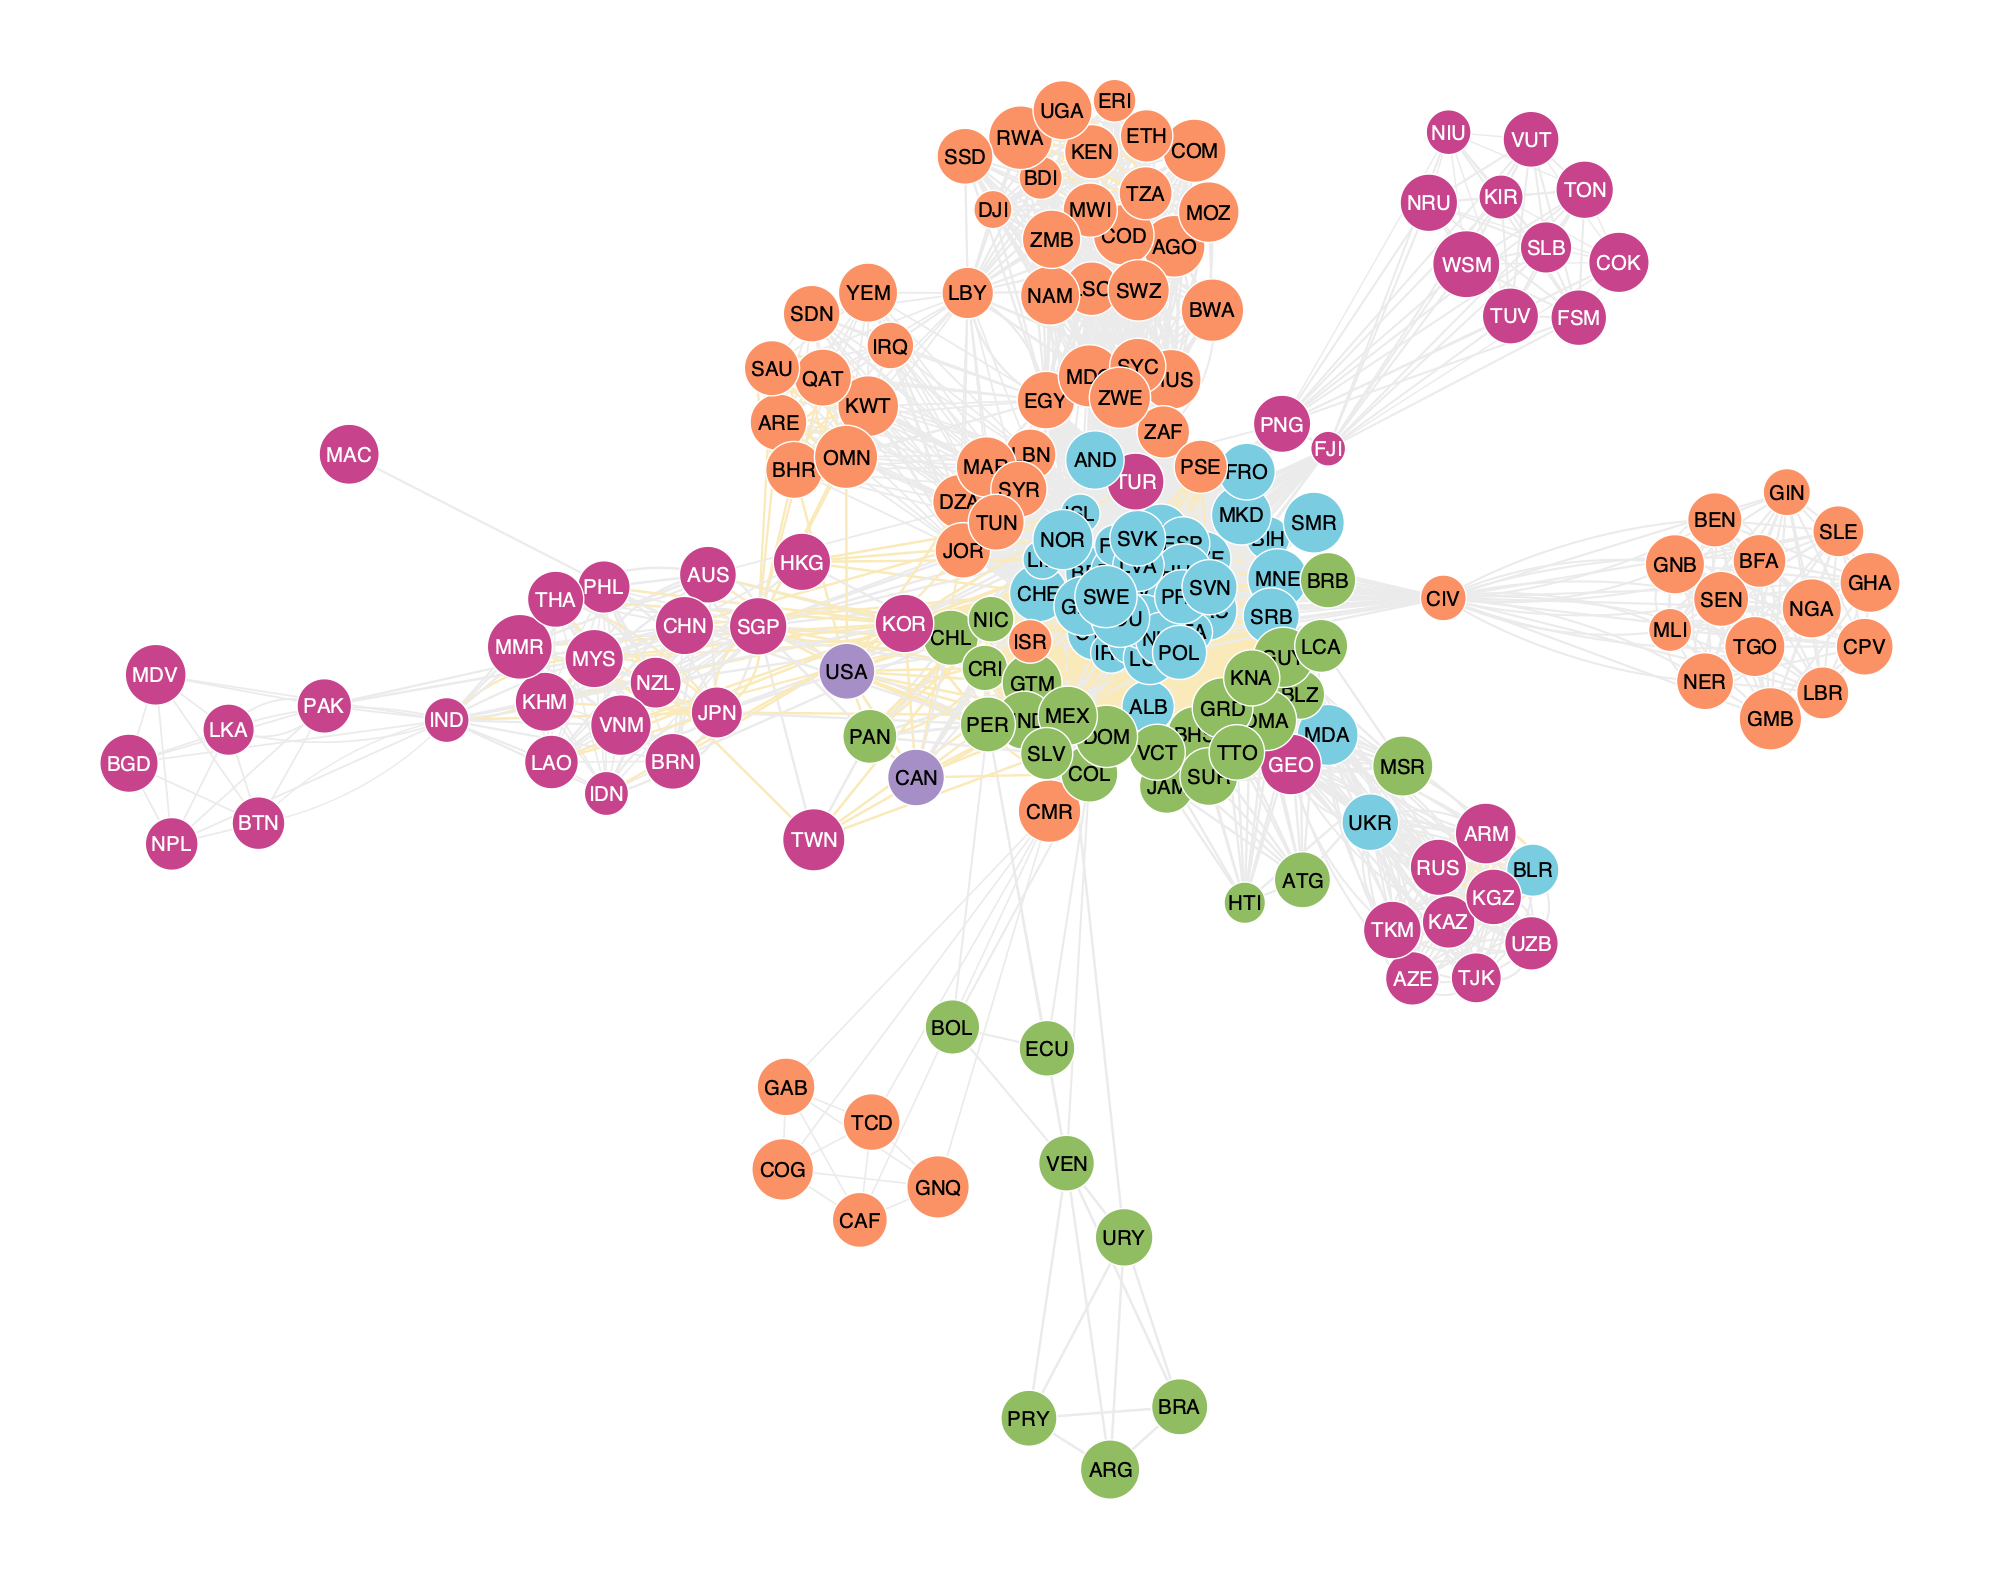

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c96cfa0, at 0x16afefa30>

In [916]:
gt.graph_draw(trade_graph, pos=pos, 
    vertex_fill_color=node_color, 
    vertex_size=17, 
    vertex_color='#FFFFFF',
    vertex_pen_width=0.7,
    vertex_anchor=0,
    vertex_font_family='sans serif',
    vertex_text=country_name,
    edge_color=edge_color,
    edge_pen_width=gt.prop_to_size(edge_weight, mi=0.7, ma=1.5),
    output_size=(1000,1000))
    #output="../charts/trade_complete.png")

In [27]:
plt.switch_backend("cairo")

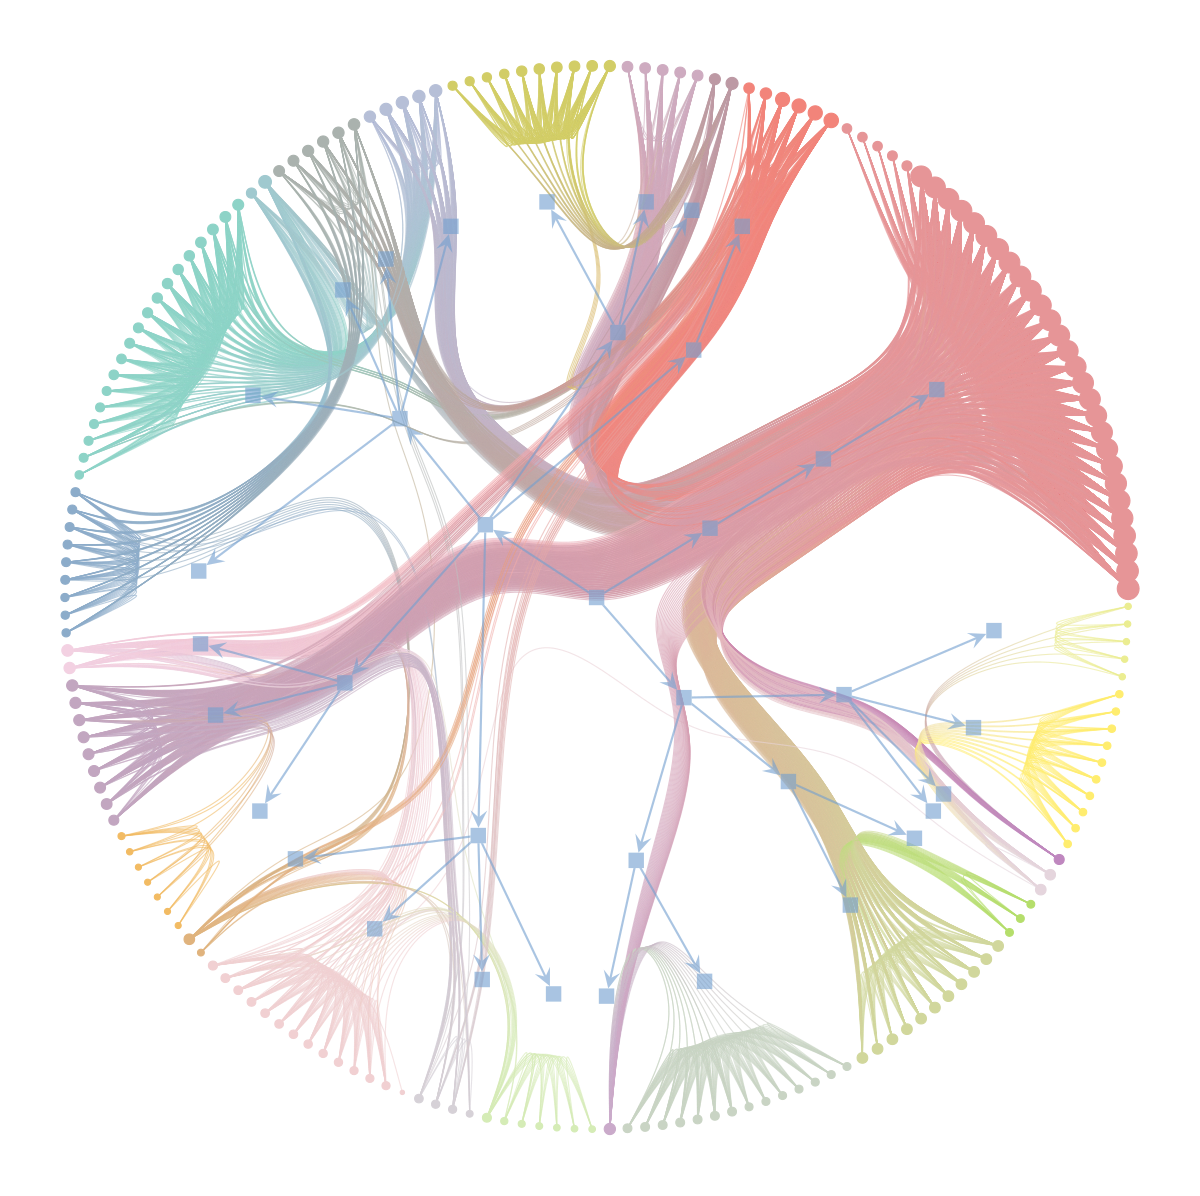

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x168ce8d30, at 0x169860fa0>,
 <GraphView object, directed, with 227 vertices and 226 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1696495e0, at 0x168d48580>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1696495e0, at 0x168d48310>, False), at 0x1696495e0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1696495e0, at 0x168d486a0>)

In [260]:
state = gt.minimize_nested_blockmodel_dl(trade_graph)
state.draw()

## III. Sub Graphs

It is also interesting to examine how the trade agreements network differs across time and different groups. To do this, I first create a function which creates a subgraph based on a filter of particular network properties.

In [938]:
def create_subgraph(main_graph, filter):
    sub = gt.GraphView(main_graph, efilt=filter)
    sub = gt.extract_largest_component(sub)
    sub = gt.Graph(sub, prune=True)
    return sub

### A. By year

*Trade agreements before 2000*

In [940]:
year_filter = trade_graph.new_edge_property("bool")
year_filter.a = trade_graph.ep.edge_year.a < 2000

sg_yr1 = create_subgraph(trade_graph, year_filter)

In [869]:
pos_yr = gt.sfdp_layout(sg_yr1)

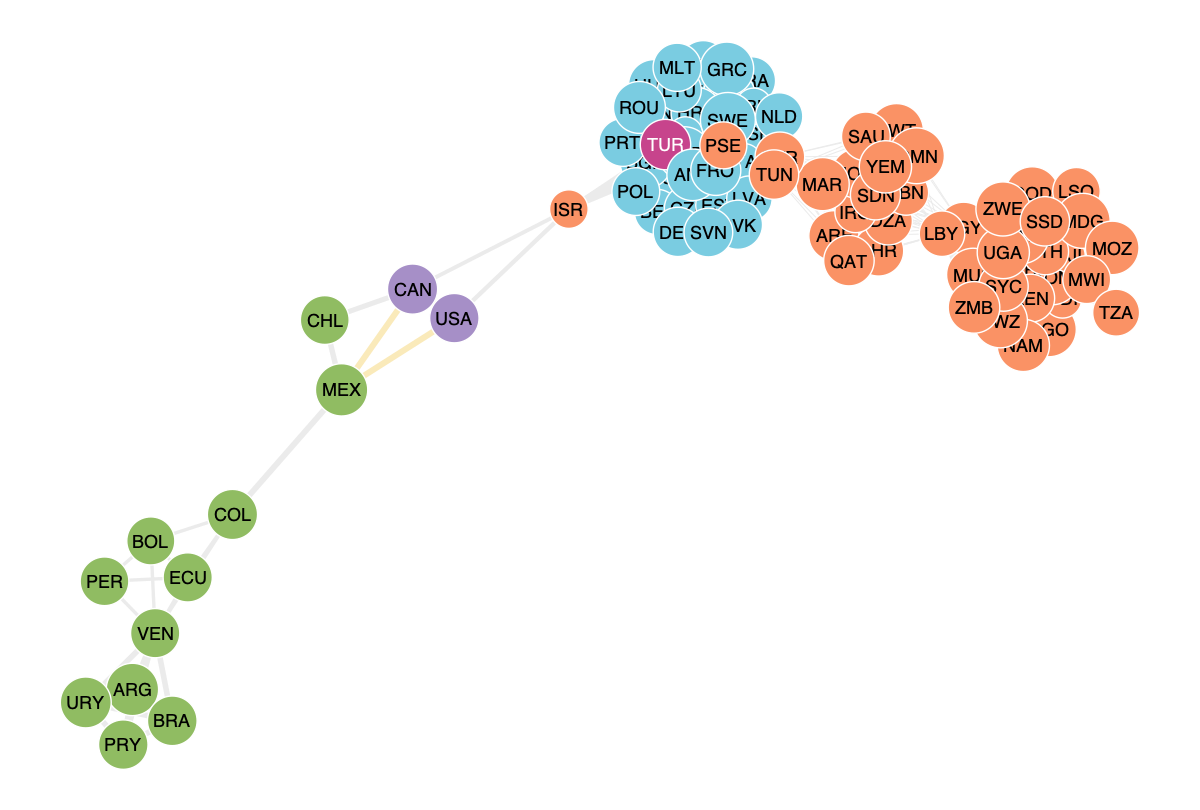

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16b022700, at 0x15c8bbaf0>

In [941]:
gt.graph_draw(sg_yr1, pos=pos_yr,
            vertex_fill_color=sg_yr1.vp.node_color, 
            vertex_size=15, 
            vertex_text=sg_yr1.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=gt.prop_to_size(sg_yr1.ep.edge_weight, mi=0.5, ma=4),
            edge_color=sg_yr1.ep.edge_color)

*Trade agreements after 2000*

In [942]:
year_filter = trade_graph.new_edge_property("bool")
year_filter.a = trade_graph.ep.edge_year.a >= 2000

sg_yr2 = create_subgraph(trade_graph, year_filter)

In [775]:
pos_yr2 = gt.sfdp_layout(sg_yr2)

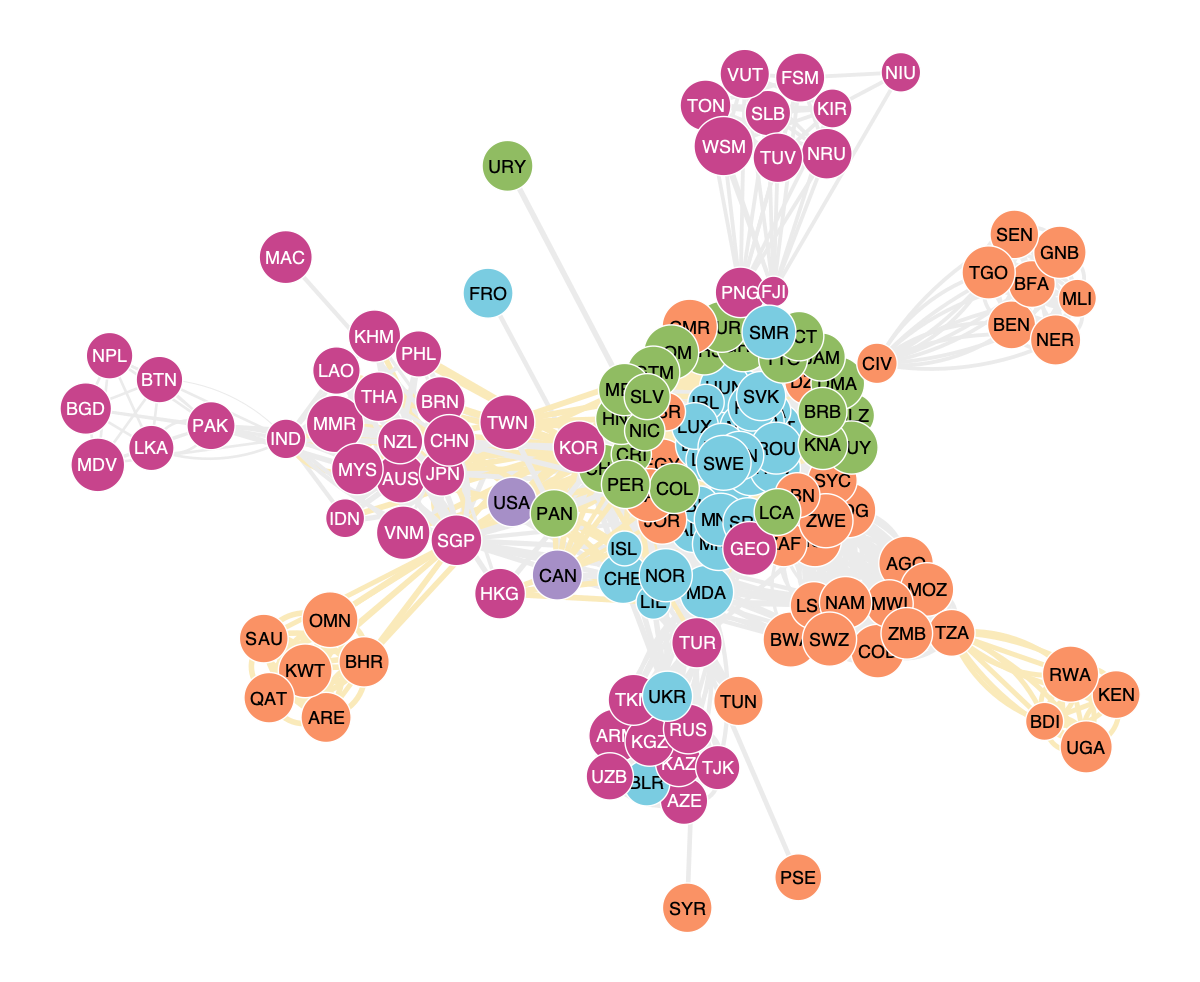

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x169f388e0, at 0x15c831760>

In [943]:
gt.graph_draw(sg_yr2, pos=pos_yr2,
            vertex_fill_color=sg_yr2.vp.node_color, 
            vertex_size=15, 
            vertex_text=sg_yr2.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=gt.prop_to_size(sg_yr2.ep.edge_weight, mi=0.5, ma=4),
            edge_color=sg_yr2.ep.edge_color)

### B. By scope

In [944]:
scope_filter = trade_graph.new_edge_property("bool")
scope_filter.a = trade_graph.ep.edge_nonecon_prov.a == 1

sg_nonecon = create_subgraph(trade_graph, scope_filter)

In [897]:
pos_scope = gt.sfdp_layout(sg_nonecon)

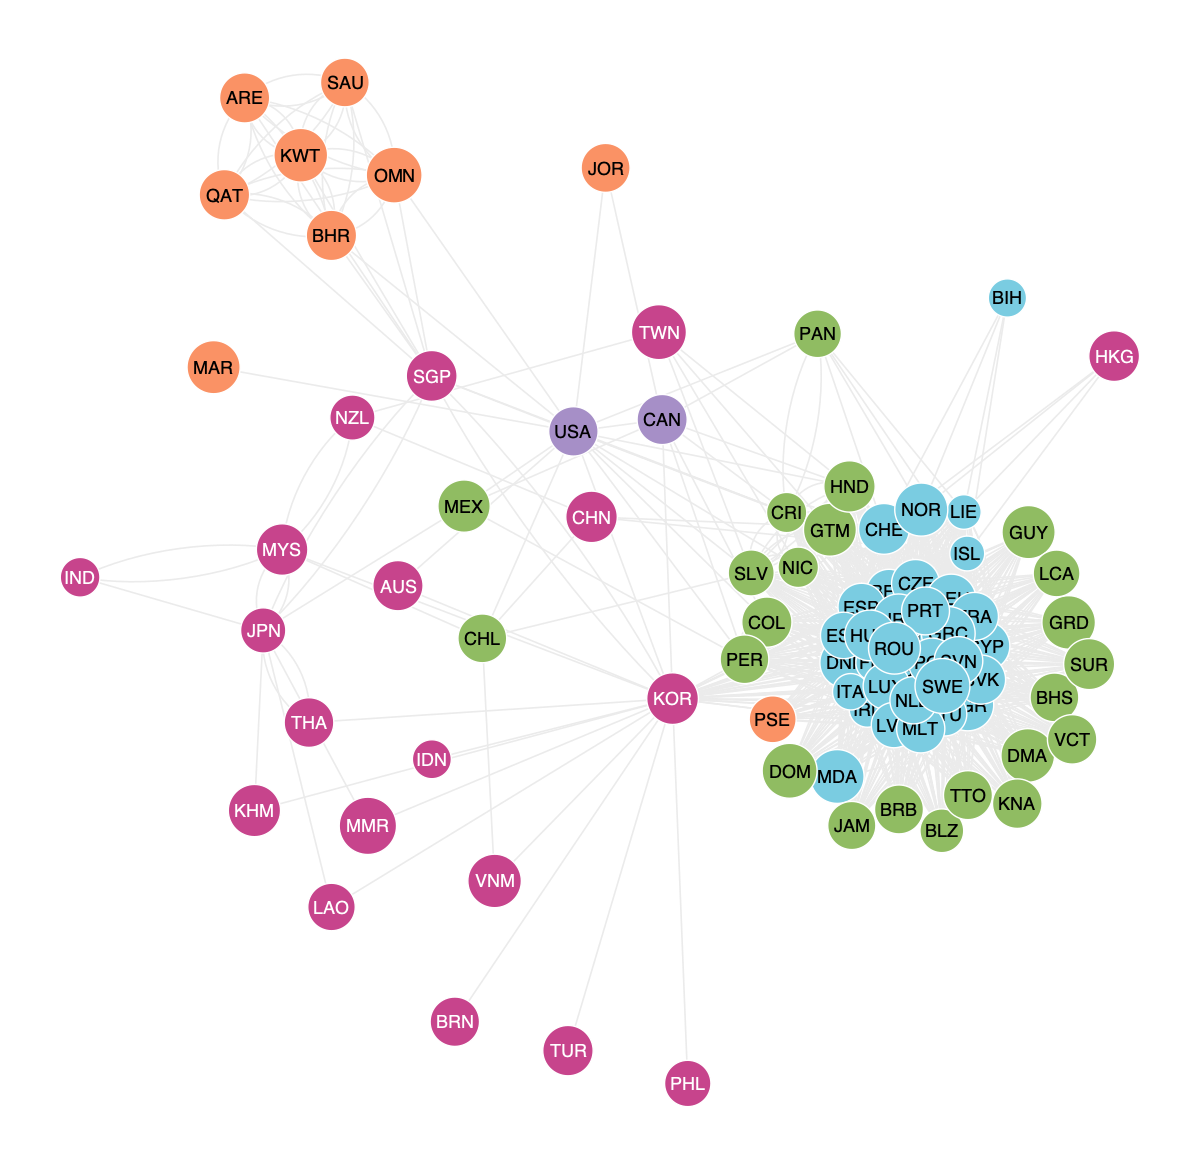

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c7eb580, at 0x15c831bb0>

In [945]:
gt.graph_draw(sg_nonecon, pos=pos_scope,
            vertex_fill_color=sg_nonecon.vp.node_color, 
            vertex_size=15, 
            vertex_text=sg_nonecon.vp.country_name, 
            vertex_font_family='sans serif',
            vertex_anchor=0,
            vertex_color='#FFFFFF',
            vertex_pen_width=0.7,
            edge_pen_width=0.8,
            edge_color='#EBEBEB')

### C. By region

## IV. Descriptive Measures

### B. Centrality 

In [946]:
color_map = colors.LinearSegmentedColormap.from_list('color_map', ['#FFFFC9', '#EA683A','#E35934', '#D53C2A', '#C71F1F'])

#### i. Full network

*Eigenvector centrality*

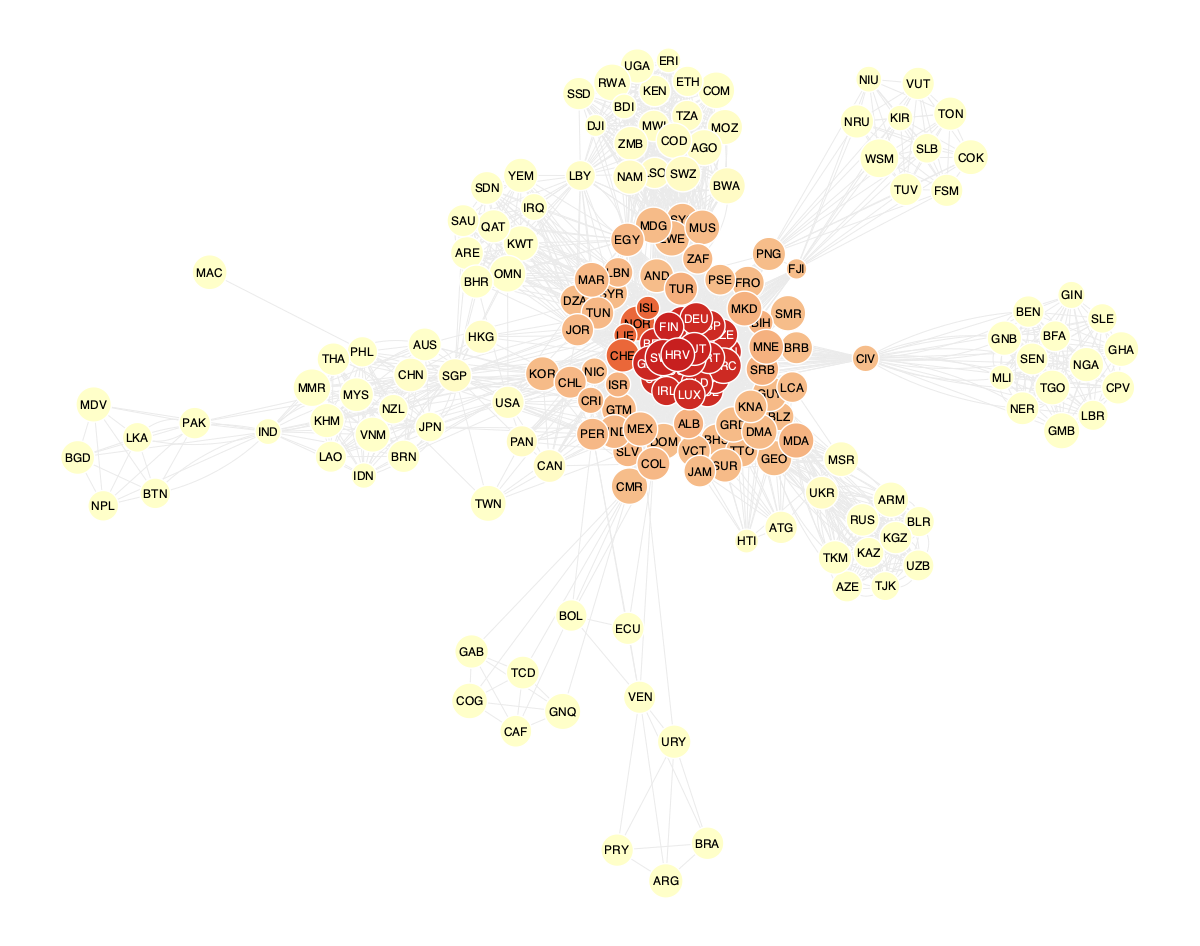

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c96cfa0, at 0x15cc5e7f0>

In [947]:
ee, x = gt.eigenvector(trade_graph)

# network based on centrality
gt.graph_draw(trade_graph, pos=pos, 
              vertex_fill_color=x,
              vertex_size=gt.prop_to_size(x, mi=8, ma=15),
              vcmap=color_map,
              vertex_text=country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)


*Betweenness centrality*

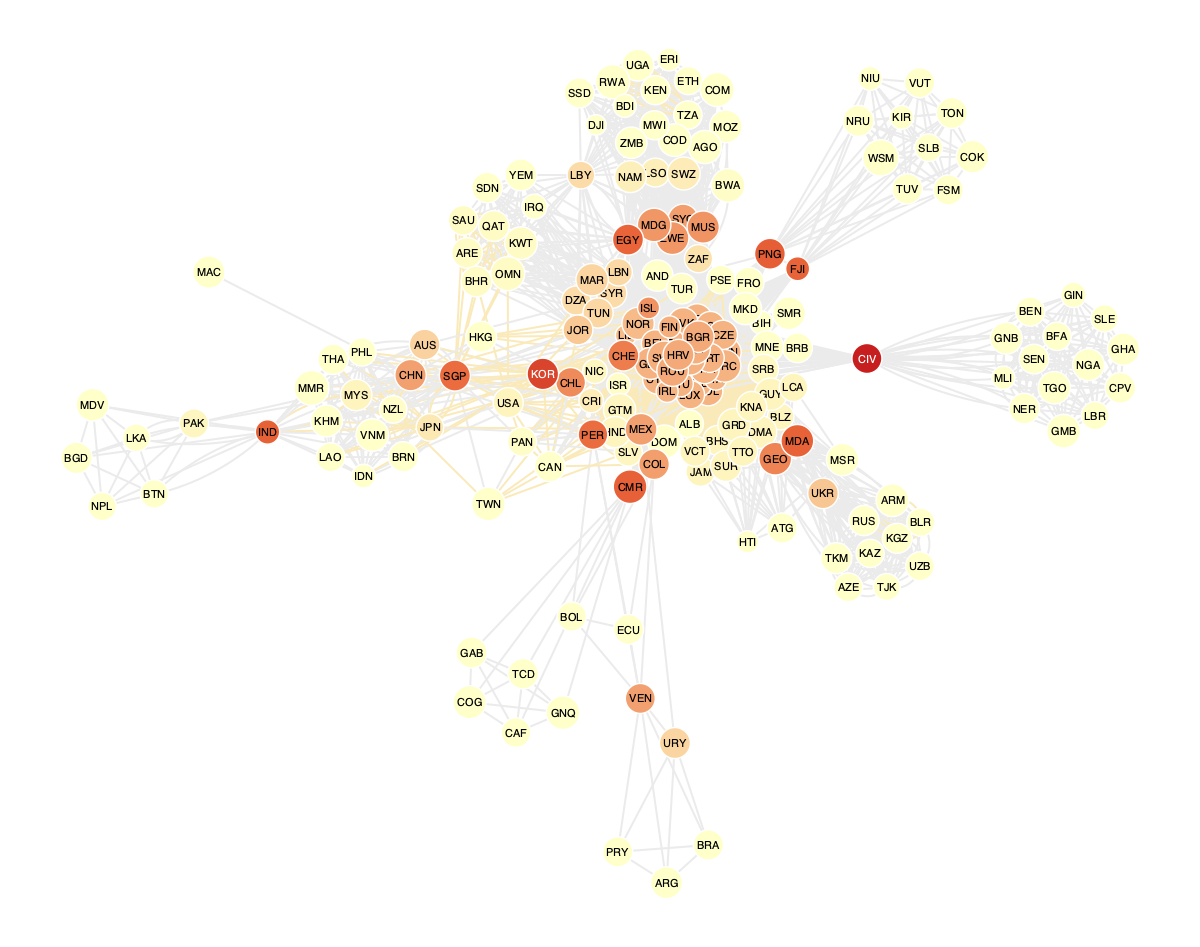

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c96cfa0, at 0x29d9ce7c0>

In [948]:
vp, ep = gt.betweenness(trade_graph)
gt.graph_draw(trade_graph, pos=pos, vertex_fill_color=vp,
              vertex_size=gt.prop_to_size(vp, mi=8, ma=15),
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color=edge_color,
              vcmap=color_map,
              vertex_text=country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              vorder=vp)

#### ii. Agreements with non-economic provisions

*Eigenvector centrality*

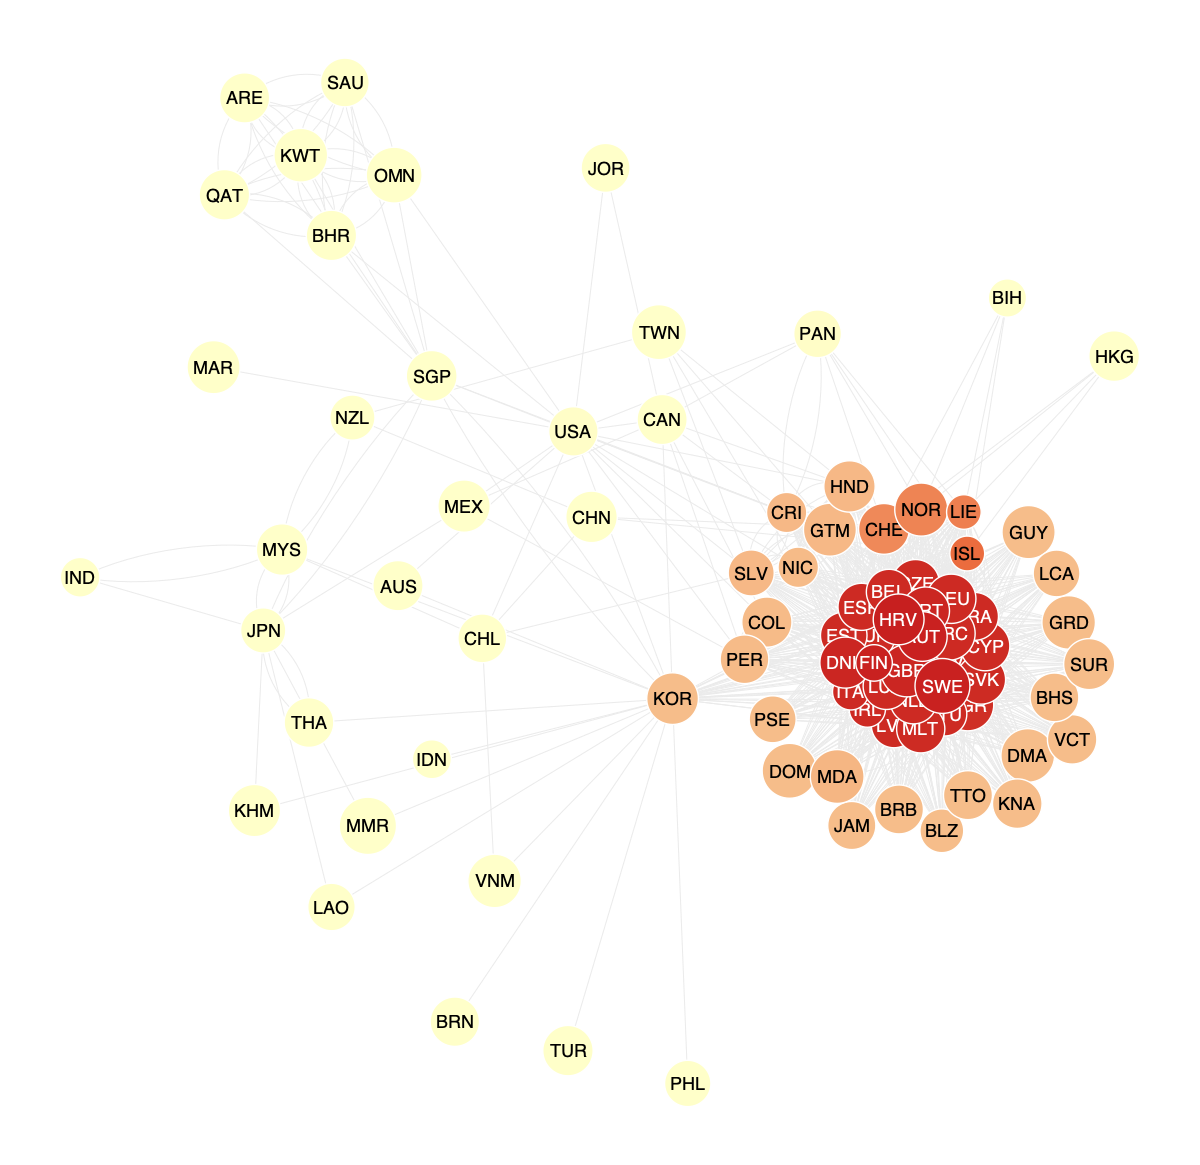

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c7eb580, at 0x15c831c10>

In [949]:
ee, x = gt.eigenvector(sg_nonecon)

# network based on centrality
gt.graph_draw(sg_nonecon, pos=pos_scope, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_nonecon.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

*Betweenness centrality*

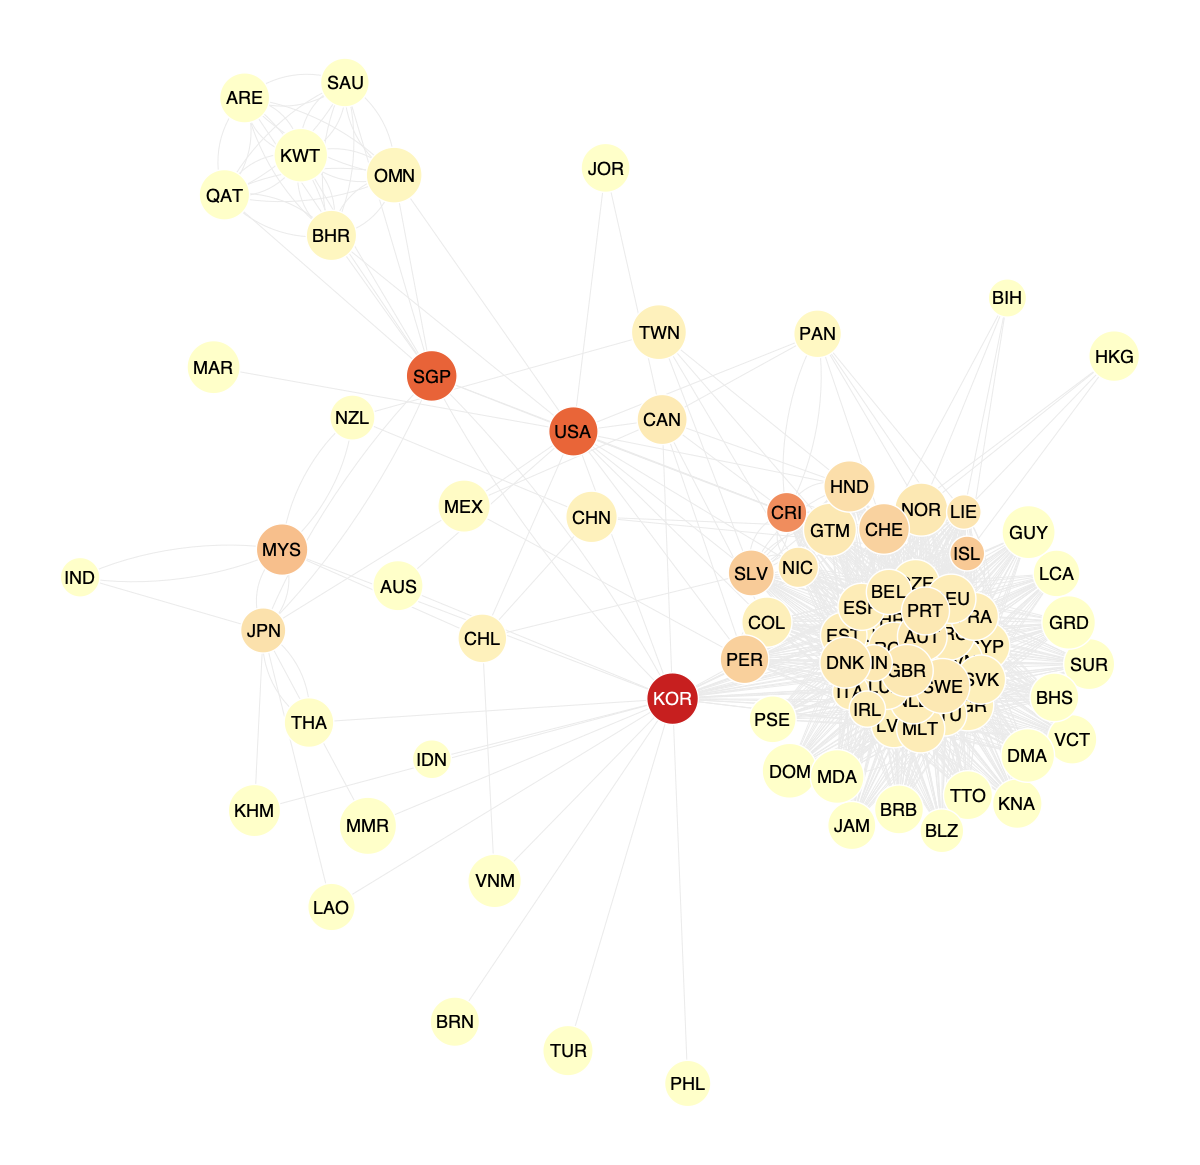

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c7eb580, at 0x160316550>

In [950]:
vp, ep = gt.betweenness(sg_nonecon)
gt.graph_draw(sg_nonecon, pos=pos_scope, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_nonecon.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)

#### iii. Agreements before 2000

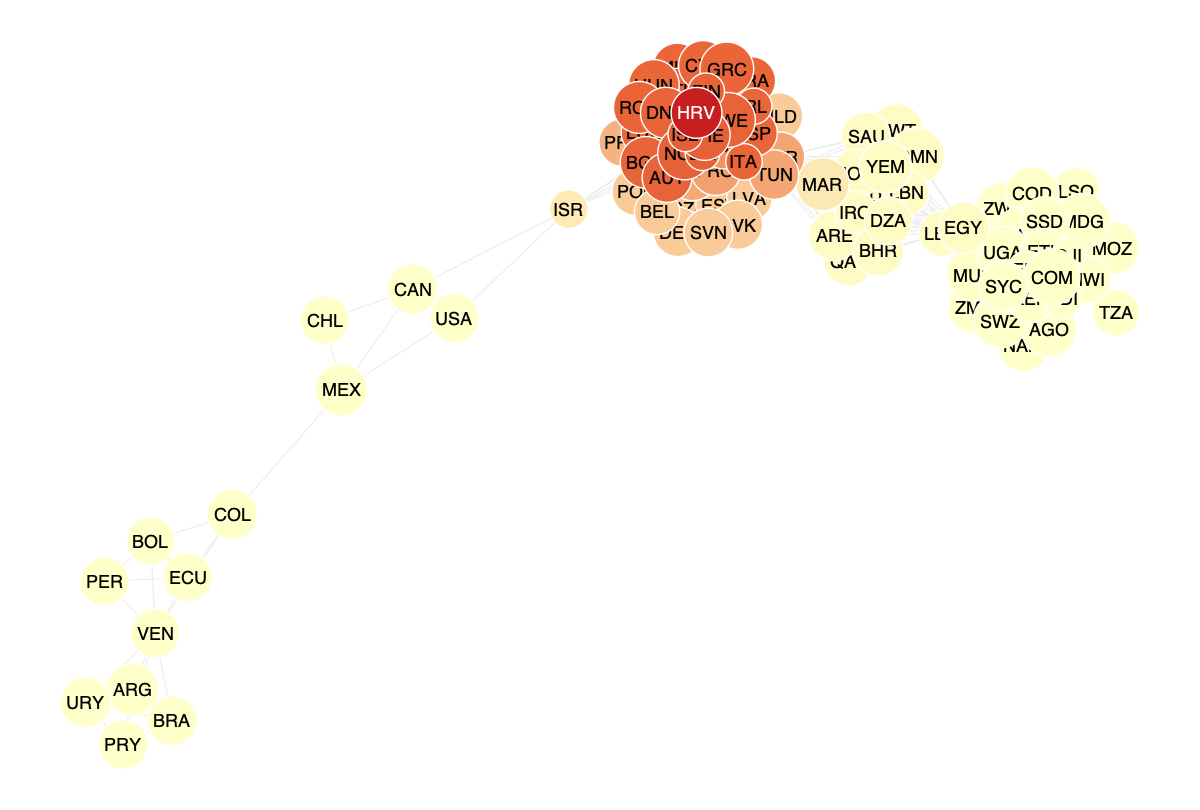

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16b022700, at 0x15c733fa0>

In [953]:
ee, x = gt.eigenvector(sg_yr1)
gt.graph_draw(sg_yr1, pos=pos_yr, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_yr1.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

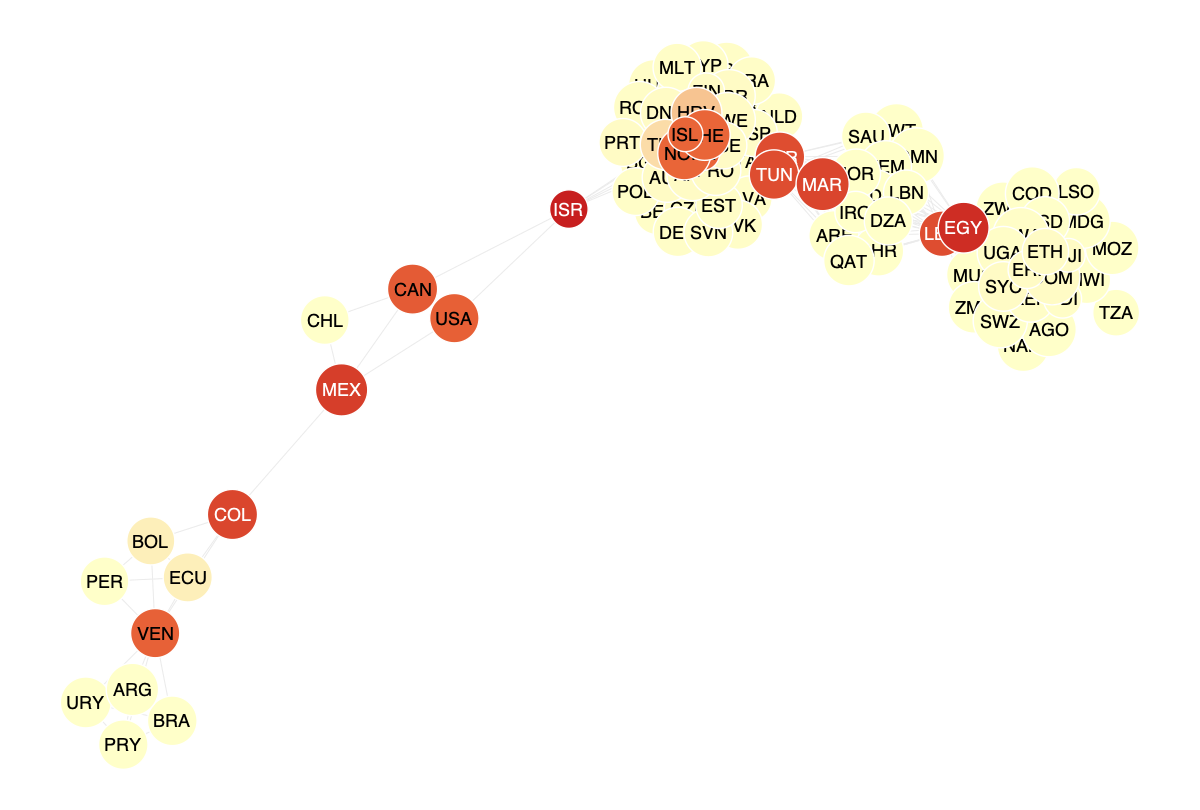

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x16b022700, at 0x15c9f3f40>

In [954]:
vp, ep = gt.betweenness(sg_yr1)
gt.graph_draw(sg_yr1, pos=pos_yr, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_yr1.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)

#### iv. Agreements after 2000

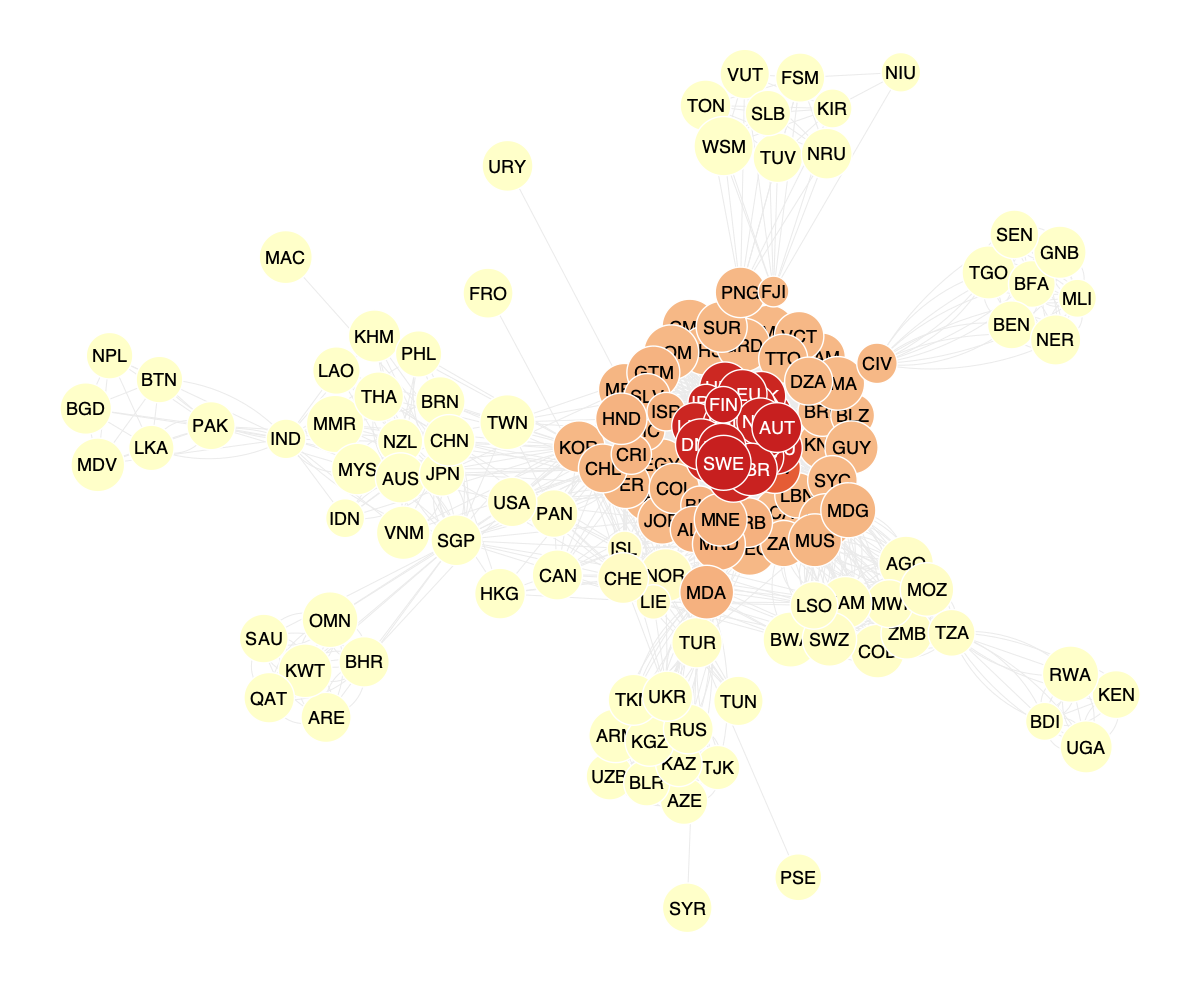

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x169f388e0, at 0x15c94e8b0>

In [955]:
ee, x = gt.eigenvector(sg_yr2)
gt.graph_draw(sg_yr2, pos=pos_yr2, 
              vertex_fill_color=x,
              vertex_size=15,
              vcmap=color_map,
              vertex_text=sg_yr2.vp.country_name,  
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              edge_color='#EBEBEB',
              vorder=x)

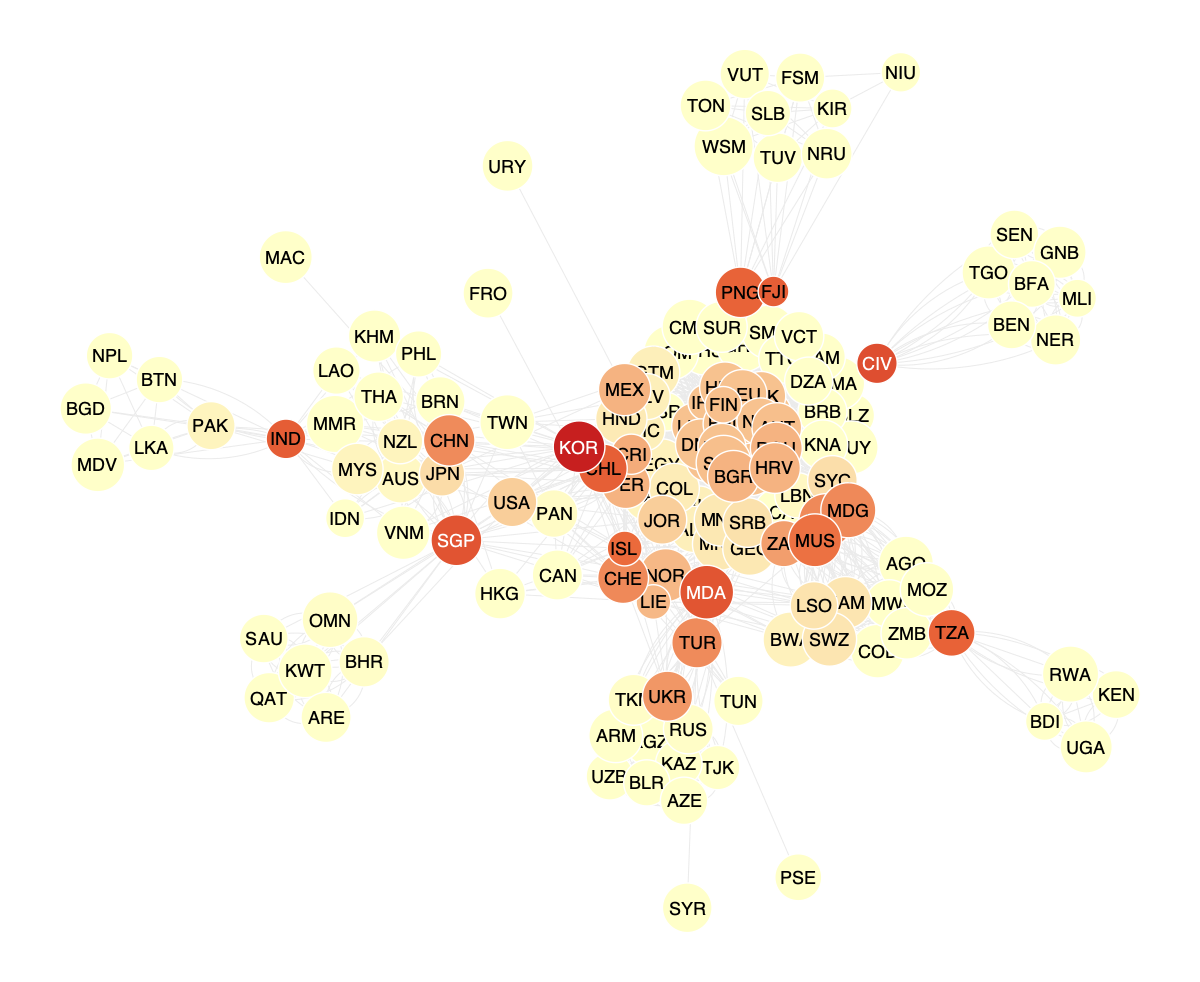

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x169f388e0, at 0x15c7dcee0>

In [956]:
vp, ep = gt.betweenness(sg_yr2)
gt.graph_draw(sg_yr2, pos=pos_yr2, vertex_fill_color=vp,
              vertex_size=15,
              #edge_pen_width=gt.prop_to_size(ep, mi=0.5, ma=5),
              edge_color='#EBEBEB',
              vcmap=color_map,
              vertex_text=sg_yr2.vp.country_name, 
              vertex_font_family='sans serif',
              vertex_color='#FFFFFF',
              vertex_pen_width=0.7,
              edge_pen_width=0.5,
              vorder=vp)